In [1]:
import os
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as mse, r2_score

os.chdir("..")

In [2]:
df_pXhat_X = pd.read_pickle("data/df_pXhat_X.pkl")
df_pY_Xhat = pd.read_pickle("data/df_pY_Xhat.pkl")
df_surprise = pd.read_pickle("data/df_surprise.pkl")

In [3]:
Ns = df_surprise.index
betas = df_surprise.columns

In [4]:
LAMBDA_STR = "\u03BB"
ALPHA_STR = "\u03B1"
BETA_STR = "\u03B2"

# Load Simulation

In [5]:
d_S = {}
path = os.path.join("data","surprise_signal_from_simulated_block")
fnames = [os.path.join(path, f) for f in os.listdir(path)]
for i, name in enumerate(fnames):
    # infer key from fname
    k = tuple(float(p) for p in os.path.splitext(name.split("\\")[-1])[0].split("_"))
    if (i+1)%500==0:
        print(i+1)
    d_S[k] = pd.read_pickle(name)

500
1000
1500
2000
2500


# Alternative Model: Linear Regression
AUC = xt*MA*w1 + (1-xt)*(MA)*w2 + xt + Const

MA is Exponential Moving Average (depend on hyperparameter alpha)

Regression will be fitted by a regularized loss (Ridge), depended on hyperparameter lambda

In [6]:
def simulate_auc(S, sigma):
    auc = S + np.random.normal(scale=sigma, size=len(S))
    if isinstance(auc, pd.Series):
        return auc.rename("AUC")
    return auc

# AUC = xt*MA*w1 + (1-xt)*(MA)*w2 + xt + Const
def preprocess_reg(df_model, ma_alpha=.1):
    out_df = df_model.copy()
    out_df["MA(t-1)"] = out_df["block"].ewm(alpha=ma_alpha).mean().shift(1)
    out_df = out_df.dropna() # shift caused dropping a value
    out_cols = {}
    out_cols['x1'] = out_df["block"] * out_df["MA(t-1)"]
    out_cols['x2'] = (1-out_df["block"]) * out_df["MA(t-1)"]
    out_cols['x3'] = out_df["block"]
    features = pd.DataFrame.from_dict(out_cols)
    return pd.concat([out_df, features], axis=1)

def split_block(data, **split_kwargs):
    train, test = train_test_split(data, **split_kwargs)
    train = train.sort_index()
    test = test.sort_index()
    return train, test

def ridge_with_ma(train, test, feature_cols, label_col="AUC", reg_lambda=1):
    reg = Ridge(alpha=reg_lambda, random_state=123)
    reg.fit(train[feature_cols], train[label_col])
    return reg

## MA conditioned on Oddball Against AUC
pre-analysis in order to define a linear model. The features of this model ("variables" or "X's") will be based on MA of t-1 trials and the current trial values.

In [7]:
N = 15
BETA = betas[11]
print(f"N:{N}", f"BETA:{BETA}")

df_model = d_S[(N, BETA)]
df_model["AUC"] = simulate_auc(df_model["S"], sigma=0.0)
df_model = df_model[["block","AUC"]].dropna()
df_model

N:15 BETA:35.564803062231285


block       AUC
15        0  0.411974
16        0  0.286554
17        0  0.286554
18        0  0.169033
19        0  0.169033
...     ...       ...
1195      0  0.957260
1196      0  0.806458
1197      0  0.667300
1198      1  1.767293
1199      1  1.522255

[1185 rows x 2 columns]

In [8]:
df_model["MA(t-1)"] = df_model["block"].ewm(alpha=.1).mean().shift(1)

xlabels are MA(t-1) ranged between 0-1


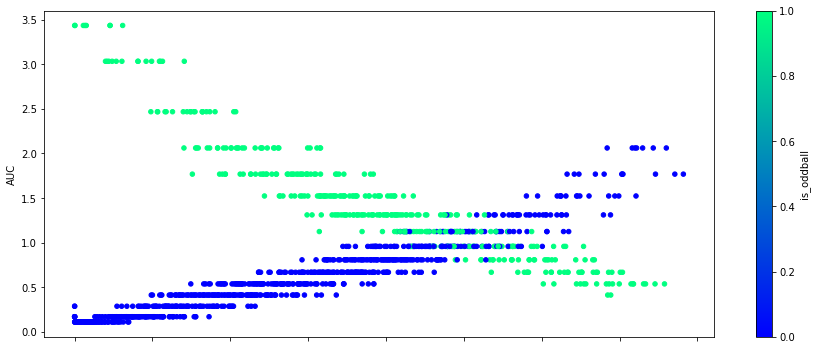

In [9]:
df_model.rename(columns={"block":"is_oddball"}).plot(
    kind="scatter", x="MA(t-1)", y="AUC", figsize=(15,6), c="is_oddball", cmap="winter");
print("xlabels are MA(t-1) ranged between 0-1")

# Apply Model to different Hyperparameters (alpha and lambda)

In [10]:
N = 25
BETA = betas[0]
print(f"N:{N}", f"BETA:{BETA}")

df_model = d_S[(N, BETA)]
df_model["AUC"] = simulate_auc(df_model["S"], sigma=0.0)
df_model = df_model[["block","AUC"]].dropna()

auc_100 = df_model['AUC']

N = 25
BETA = betas[17]
print(f"N:{N}", f"BETA:{BETA}")

df_model = d_S[(N, BETA)]
df_model["AUC"] = simulate_auc(df_model["S"], sigma=0.0)
df_model = df_model[["block","AUC"]].dropna()

auc_20 = df_model['AUC']


N = 25
BETA = betas[40]
print(f"N:{N}", f"BETA:{BETA}")

df_model = d_S[(N, BETA)]
df_model["AUC"] = simulate_auc(df_model["S"], sigma=0.0)
df_model = df_model[["block","AUC"]].dropna()

auc_10 = df_model['AUC']

N:25 BETA:100.0
N:25 BETA:20.235896477251575
N:25 BETA:2.329951810515373


In [11]:
pd.concat([auc_10.rename("beta=2"),auc_20.rename("beta=20"), auc_100.rename("beta=100")],axis=1).plot(backend="plotly")

In [11]:
data_with_features = preprocess_reg(df_model, ma_alpha=0.1)
train, test = split_block(data_with_features, test_size=.2, random_state=123)
d_lambda = {}
feature_cols=['x1','x2','x3']

## Tune Lambda (Regularization) and Fix Alpha (MA)

In [12]:
lambdas = np.linspace(0,5, num=100)
for l in range(len(lambdas)):
    d_lambda[l] = {}
    reg = ridge_with_ma(train, test,feature_cols=feature_cols, reg_lambda=lambdas[l])
    train_preds = reg.predict(train[feature_cols])
    test_preds = reg.predict(test[feature_cols])
    
    d_lambda[l]["lambda"] = lambdas[l]
    d_lambda[l]["reg"] = reg
    d_lambda[l]["r2"] = r2_score(train["AUC"], train_preds)
    d_lambda[l]["train_mse"] = mse(train["AUC"], train_preds)
    d_lambda[l]["test_mse"] = mse(test["AUC"], test_preds)

df_res = pd.DataFrame.from_dict(d_lambda).T
reg_obj_col = df_res['reg'].values
df_res = df_res.drop(columns="reg").astype(float)
df_res['reg'] = reg_obj_col

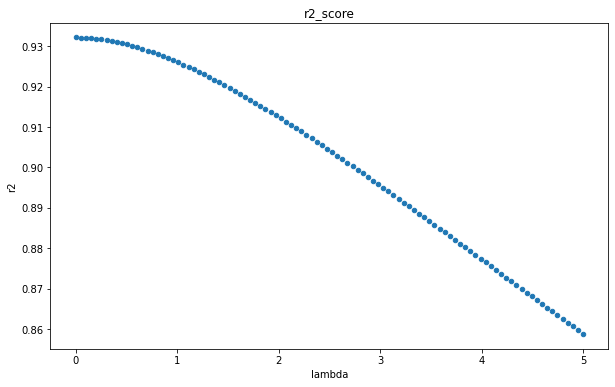

In [13]:
df_res.plot(kind="scatter", x="lambda", y="r2", title="r2_score", figsize=(10,6))
plt.show()

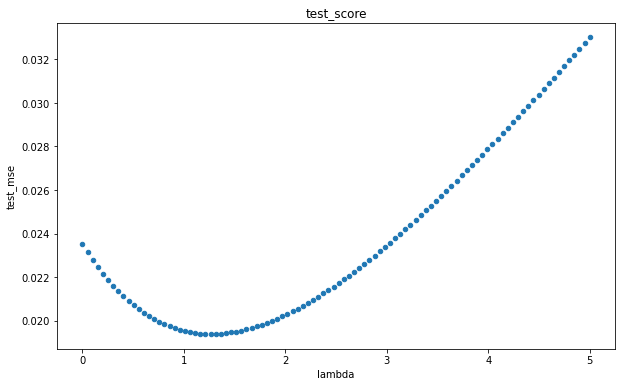

In [14]:
df_res.plot(kind="scatter", x="lambda", y="test_mse", title="test_score", figsize=(10,6))
plt.show()

### Choose Best Lambda and See fit

In [15]:
best_lambda, reg = df_res.loc[df_res['test_mse'].argmin(), ['lambda','reg']]

In [16]:
preds = reg.predict(data_with_features[feature_cols])

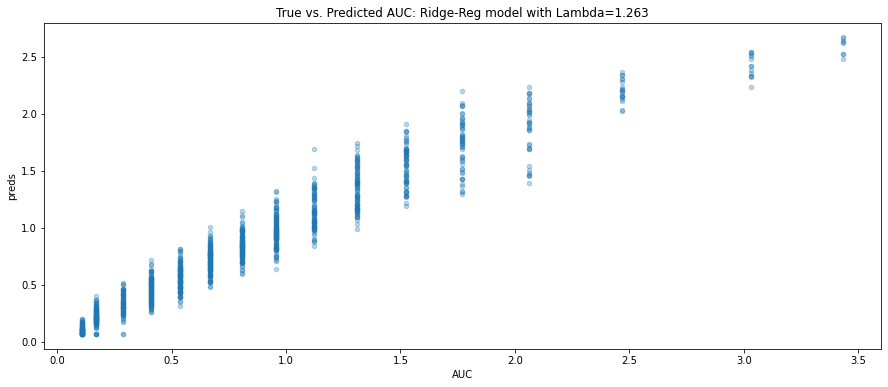

In [17]:
pd.concat([data_with_features['AUC'], pd.Series(preds, index=data_with_features.index, name="preds")], axis=1).plot(
    kind="scatter", x="AUC", y="preds", figsize=(15,6), alpha=.3)
plt.title(f"True vs. Predicted AUC: Ridge-Reg model with Lambda={np.round(best_lambda,3)}")
plt.show()

## Tune Alpha

In [18]:
N = 15
BETA = betas[11]
print(f"N:{N}", f"BETA:{BETA}")

df_model = d_S[(N, BETA)]
df_model["AUC"] = simulate_auc(df_model["S"], sigma=0.0)
df_model = df_model[["block","AUC"]].dropna()

N:15 BETA:35.564803062231285


In [19]:
alphas = np.linspace(1e-3, 1)
LAMBDA = 1.2
d_alpha = {}

for a in range(len(alphas)):
    d_alpha[a] = {}
    
    data_with_features = preprocess_reg(df_model, ma_alpha=alphas[a])
    train, test = split_block(data_with_features, test_size=.2, random_state=123)
    feature_cols=['x1','x2','x3']
    reg = ridge_with_ma(train, test,feature_cols=feature_cols, reg_lambda=LAMBDA)
    
    train_preds = reg.predict(train[feature_cols])
    test_preds = reg.predict(test[feature_cols])
    
    d_alpha[a]["alpha"] = alphas[a]
    d_alpha[a]["reg"] = reg
    d_alpha[a]["r2"] = r2_score(train["AUC"], train_preds)
    d_alpha[a]["train_mse"] = mse(train["AUC"], train_preds)
    d_alpha[a]["test_mse"] = mse(test["AUC"], test_preds)

df_res = pd.DataFrame.from_dict(d_alpha).T
reg_obj_col = df_res['reg'].values
df_res = df_res.drop(columns="reg").astype(float)
df_res['reg'] = reg_obj_col

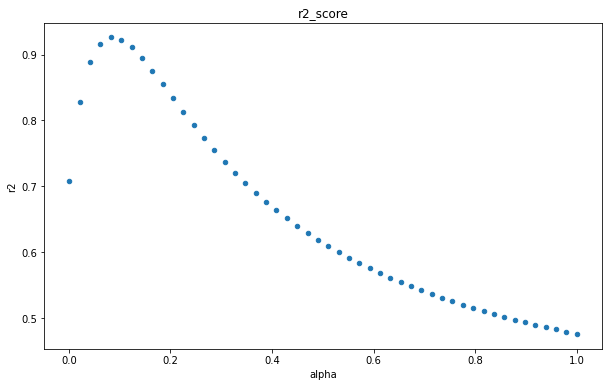

In [20]:
df_res.plot(kind="scatter", x="alpha", y="r2", title="r2_score", figsize=(10,6))
plt.show()

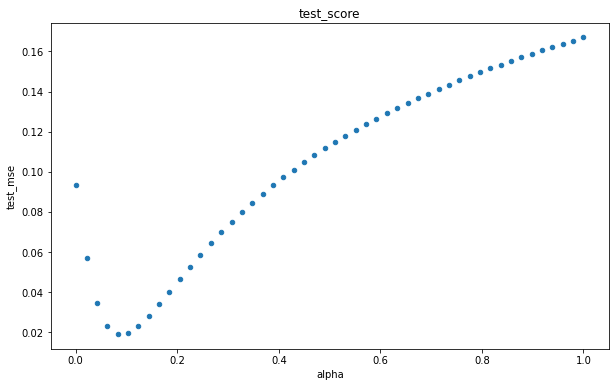

In [21]:
df_res.plot(kind="scatter", x="alpha", y="test_mse", title="test_score", figsize=(10,6))
plt.show()

### Choose Best Alpha and See fit

In [22]:
best_alpha, reg = df_res.loc[df_res['test_mse'].argmin(), ['alpha','reg']]

In [23]:
data_with_features = preprocess_reg(df_model, ma_alpha=best_alpha)
preds = reg.predict(data_with_features[feature_cols])

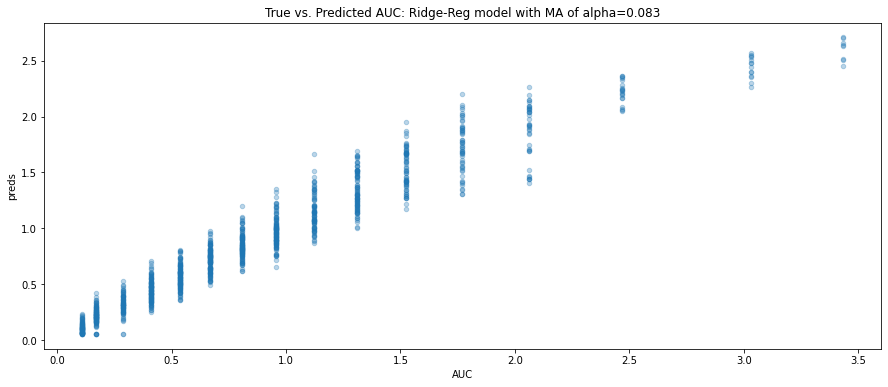

In [24]:
pd.concat([data_with_features['AUC'], pd.Series(preds, index=data_with_features.index, name="preds")], axis=1).plot(
    kind="scatter", x="AUC", y="preds", figsize=(15,6), alpha=.3)
plt.title(f"True vs. Predicted AUC: Ridge-Reg model with MA of alpha={np.round(best_alpha,3)}")
plt.show()

# Tune Both Alpha (MA) and Lambda (Regularization)

In [119]:
N = 4
BETA = betas[5]
print(f"N:{N}", f"BETA:{BETA}")

df_model = d_S[(N, BETA)]
df_model["AUC"] = simulate_auc(df_model["S"], sigma=0.0)
df_model = df_model[["block","AUC"]].dropna()

N:4 BETA:62.50551925273973


In [168]:
lambdas = np.linspace(0,10)
alphas = np.linspace(1e-3, 1)

d_regs = {}
for n in range(0,len(Ns)):
    for b in range(0,len(betas)):
        N = Ns[n]
        BETA = betas[b]
        df_model = d_S[(N, BETA)]
        df_model["AUC"] = simulate_auc(df_model["S"], sigma=0.0)
        df_model = df_model[["block","AUC"]].dropna()

        results = []
        print(f"N:{N}", f"BETA:{BETA}")
        for a in tqdm(range(len(alphas))):
            data_with_features = preprocess_reg(df_model, ma_alpha=alphas[a])
            train, test = split_block(data_with_features, test_size=.2, random_state=123)
            for l in range(len(lambdas)):

                reg = ridge_with_ma(train, test,feature_cols=feature_cols, reg_lambda=lambdas[l])
                train_preds = reg.predict(train[feature_cols])
                test_preds = reg.predict(test[feature_cols])

                results.append(
                    (alphas[a], lambdas[l], reg, r2_score(train["AUC"], train_preds), 
                     mse(train["AUC"], train_preds), mse(test["AUC"], test_preds))
                )

        df_res = pd.DataFrame.from_records(results, columns=["alpha", "lambda", "reg", "r2", "train_mse", "test_mse"])
        reg_obj_col = df_res['reg'].values
        df_res = df_res.drop(columns="reg").astype(float)
        df_res['reg'] = reg_obj_col
        d_regs[(N,BETA)] = df_res

N:1 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.19it/s]


N:1 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.23it/s]


N:1 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:20<00:00,  2.41it/s]


N:1 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.24it/s]


N:1 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:20<00:00,  2.39it/s]


N:1 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.23it/s]


N:1 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.28it/s]


N:1 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.67it/s]


N:1 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.30it/s]


N:1 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:41<00:00,  1.21it/s]


N:1 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


N:1 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:43<00:00,  1.15it/s]


N:1 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.58it/s]


N:1 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:20<00:00,  2.49it/s]


N:1 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:23<00:00,  2.10it/s]


N:1 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.54it/s]


N:1 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.04it/s]


N:1 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.79it/s]


N:1 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.38it/s]


N:1 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.78it/s]


N:1 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.70it/s]


N:1 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.78it/s]


N:1 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.55it/s]


N:1 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.67it/s]


N:1 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.18it/s]


N:1 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:23<00:00,  2.12it/s]


N:1 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:20<00:00,  2.43it/s]


N:1 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.70it/s]


N:1 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:20<00:00,  2.39it/s]


N:1 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.54it/s]


N:1 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.85it/s]


N:1 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.73it/s]


N:1 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.91it/s]


N:1 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.86it/s]


N:1 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.78it/s]


N:1 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.77it/s]


N:1 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.51it/s]


N:1 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:1 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:1 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.03it/s]


N:1 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:1 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:1 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:1 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:1 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:20<00:00,  2.50it/s]


N:1 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.30it/s]


N:1 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.60it/s]


N:1 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.31it/s]


N:1 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.93it/s]


N:1 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.76it/s]


N:2 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:2 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.22it/s]


N:2 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:20<00:00,  2.47it/s]


N:2 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.70it/s]


N:2 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.63it/s]


N:2 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:23<00:00,  2.12it/s]


N:2 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.73it/s]


N:2 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.83it/s]


N:2 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:2 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.71it/s]


N:2 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  2.98it/s]


N:2 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:2 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:2 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:2 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:2 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:2 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:2 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:2 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:2 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:2 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:2 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:2 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:2 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:2 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:2 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:2 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:2 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:2 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:2 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:2 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:2 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:2 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:2 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:2 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:2 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:2 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:2 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.26it/s]


N:2 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:2 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:2 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:2 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.26it/s]


N:2 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:2 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:2 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:2 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:2 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:2 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:2 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:2 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:3 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:3 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:3 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:3 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:3 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:3 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:3 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:3 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:3 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:3 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  2.98it/s]


N:3 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:3 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:3 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:3 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:3 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:3 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:3 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:3 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:3 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:3 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:3 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:3 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:3 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:3 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:3 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:3 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:3 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:3 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:3 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:3 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:3 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:3 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:3 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:3 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:3 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:3 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:3 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:3 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:3 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:3 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:3 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:3 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:3 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:3 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:3 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:3 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:3 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:3 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:3 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:3 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:4 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:4 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:4 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:4 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.26it/s]


N:4 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:4 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:4 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  2.98it/s]


N:4 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:4 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:4 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:4 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:4 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:4 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:4 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:4 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:4 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:4 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:4 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:4 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:4 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:4 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.26it/s]


N:4 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:4 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:4 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:4 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:4 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:4 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:4 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:4 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:4 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:4 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:4 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:4 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:4 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:4 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:4 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:4 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:4 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:4 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:4 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:4 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:4 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:4 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:4 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:4 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:4 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:4 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:4 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:4 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:4 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.26it/s]


N:5 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:5 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:5 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:5 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:5 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:5 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:5 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:5 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:5 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:5 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:5 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:5 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:5 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:5 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:5 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:5 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:5 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:5 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:5 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:5 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:5 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:5 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:5 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:5 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:5 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:5 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:5 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:5 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:5 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:5 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:5 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.26it/s]


N:5 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:5 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:5 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:5 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:5 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:5 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:5 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:5 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:5 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:5 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:5 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:5 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:5 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:5 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:5 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:5 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:5 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:5 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:5 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:6 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:6 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:6 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:6 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:6 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:6 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:6 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:6 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:6 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:6 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:6 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:6 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:6 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:6 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:6 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:6 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.26it/s]


N:6 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:6 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:6 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:6 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.26it/s]


N:6 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:6 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:6 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:6 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:6 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:6 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:6 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:6 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:6 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:6 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:6 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:6 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:6 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:6 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:6 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:6 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:6 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:6 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:6 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:6 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:6 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:6 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:6 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:6 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:6 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:6 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:6 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:6 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:6 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:6 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:7 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:7 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:7 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:7 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:7 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:7 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:7 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:7 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:7 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:7 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:7 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:7 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:7 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:7 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:7 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:7 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:7 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:7 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:7 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:7 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.27it/s]


N:7 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:7 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:7 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:7 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:7 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:7 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:7 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:7 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:7 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:7 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:7 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:7 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:7 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:7 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:7 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:7 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:7 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:7 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:7 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:7 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:7 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:7 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:7 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:7 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:7 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:7 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:7 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:7 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:7 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:7 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:8 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:8 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:8 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:8 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:8 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:8 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:8 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:8 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:8 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:8 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:8 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:8 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:8 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:8 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:8 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:8 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:8 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:8 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:8 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:8 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:8 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:8 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:8 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:8 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:8 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:8 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:8 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:8 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:8 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:8 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:8 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:8 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:8 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:8 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:8 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:8 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:8 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:8 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:8 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:8 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:8 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:8 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:8 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:8 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:8 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:8 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:8 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:8 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:8 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:8 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:9 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:9 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:9 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:9 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:9 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:9 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:9 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:9 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:9 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:9 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:9 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:9 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:9 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:9 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:9 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


N:9 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:9 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:9 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:9 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:9 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:9 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:9 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:9 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:9 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:9 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:9 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:9 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:9 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:9 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:9 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:9 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:9 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:9 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:9 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:9 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:9 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:9 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:9 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:9 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:9 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:9 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:9 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:9 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:9 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:9 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:9 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:9 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:9 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:9 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:9 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:10 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:10 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:10 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:10 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:10 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:10 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:10 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:10 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:10 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:10 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:10 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:10 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:10 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:10 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:10 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:10 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:10 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:10 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:10 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:10 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:10 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:10 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:10 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:10 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:10 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:10 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:10 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:10 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:10 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:10 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:10 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:10 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:10 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:10 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:10 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:10 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:10 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:10 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:10 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:10 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:10 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:10 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


N:10 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:10 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:10 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:10 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:10 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:10 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:10 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:10 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:11 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:11 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:11 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:11 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:11 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:11 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:11 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:11 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:11 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:11 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:11 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:11 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:11 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:11 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:11 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:11 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:11 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:11 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:11 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:11 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:11 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:11 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:11 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:11 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:11 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:11 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:11 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:11 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.03it/s]


N:11 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:11 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:11 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:11 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:11 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:11 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:11 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:11 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:11 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:11 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:11 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:11 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:11 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:11 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:11 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:11 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:11 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:11 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:11 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:11 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:11 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:11 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:12 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:12 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:12 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:12 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:12 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:12 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:12 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:12 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:12 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:12 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:12 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:12 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:12 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:12 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:12 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:12 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:12 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:12 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:12 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:12 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:12 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:12 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:12 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:12 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:12 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:12 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:12 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:12 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:12 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:12 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:12 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:12 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:12 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:12 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:12 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:12 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:12 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:12 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:12 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:12 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:12 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:12 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:12 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:12 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:12 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:12 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:12 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:12 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:12 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:12 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:13 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:13 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:13 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:13 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:13 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:13 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:13 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:13 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:13 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:13 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:13 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:13 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:13 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:13 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:13 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:13 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:13 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:13 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:13 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:13 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:13 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:13 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:13 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:13 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:13 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:13 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:13 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:13 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:13 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:13 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:13 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:13 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:13 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:13 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:13 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:13 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:13 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:13 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:13 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:13 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:13 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:13 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:13 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:13 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:13 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:13 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:13 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:13 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:13 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:13 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:14 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:14 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:14 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:14 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:14 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:14 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:14 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:14 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:14 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:14 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:14 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:14 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:14 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:14 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:14 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:14 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:14 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:14 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:14 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:14 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:14 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:14 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:14 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:14 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:14 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:14 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:14 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:14 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:14 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:14 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


N:14 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:14 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:14 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:14 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:14 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:14 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:14 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:14 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:14 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:14 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:14 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:14 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:14 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:14 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:14 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:14 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:14 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:14 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:14 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:14 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:15 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:15 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:15 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:15 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:15 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:15 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:15 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:15 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:15 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:15 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:15 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:15 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:15 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:15 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:15 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:15 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:15 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:15 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:15 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:15 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:15 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:15 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:15 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:15 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:15 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:15 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:15 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:15 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:15 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:15 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:15 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:15 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:15 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:15 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:15 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:15 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:15 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:15 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:15 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:15 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:15 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:15 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:15 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:15 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:15 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:15 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:15 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:15 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:15 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:15 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:16 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:16 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:16 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:16 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:16 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:16 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:16 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:16 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:16 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:16 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:16 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:16 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:16 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:16 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:16 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:16 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:16 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:16 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:16 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:16 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:16 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:16 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:16 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:16 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:16 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:16 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:16 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:16 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


N:16 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:16 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:16 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:16 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:16 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:16 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:16 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:16 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:16 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:16 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:16 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:16 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:16 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:16 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:16 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:16 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:16 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:16 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:16 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:16 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:16 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:16 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:17 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:17 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:17 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:17 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:17 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:17 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:17 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:17 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:17 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:17 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:17 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:17 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:17 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:17 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:17 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:17 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:17 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:17 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:17 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:17 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:17 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:17 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:17 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:17 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:17 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:17 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:17 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:17 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:17 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:17 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:17 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:17 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:17 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:17 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:17 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:17 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:17 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:17 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:17 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:17 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:17 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:17 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:17 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:17 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:17 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:17 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:17 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:17 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:17 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:17 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:18 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:18 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:18 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:18 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:18 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:18 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:18 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:18 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:18 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:18 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:18 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:18 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:18 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:18 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:18 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:18 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:18 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:18 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:18 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:18 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:18 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:18 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:18 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:18 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:18 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:18 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:18 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:18 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:18 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:18 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:18 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:18 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:18 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:18 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:18 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:18 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:18 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:18 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:18 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:18 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:18 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:18 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:18 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:18 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:18 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:18 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:18 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:18 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:18 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:18 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:19 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:19 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:19 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:19 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:19 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:19 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:19 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:19 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:19 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:19 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:19 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:19 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


N:19 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:19 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:19 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:19 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:19 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:19 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:19 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:19 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:19 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:19 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:19 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:19 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:19 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:19 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:19 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:19 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:19 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:19 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:19 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:19 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:19 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:19 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:19 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:19 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:19 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:19 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:19 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:19 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:19 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:19 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:19 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:19 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:19 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:19 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:19 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:19 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:19 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:19 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:20 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:20 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:20 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:20 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:20 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:20 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:20 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:20 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:20 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:20 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:20 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:20 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:20 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:20 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:20 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:20 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:20 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:20 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:20 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:20 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:20 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:20 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:20 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:20 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:20 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:20 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:20 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:20 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:20 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:20 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:20 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:20 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:20 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:20 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:20 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:20 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:20 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:20 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:20 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:20 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:20 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:20 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:20 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:20 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:20 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:20 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:20 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:20 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:20 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:20 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:21 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:21 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:21 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:21 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:21 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:21 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:21 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:21 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:21 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:21 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:21 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:21 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:21 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:21 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:21 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:21 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:21 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:21 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:21 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:21 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:21 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:21 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:21 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]


N:21 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:21 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:21 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:21 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:21 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:21 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:21 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:21 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:21 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:21 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:21 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:21 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:21 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:21 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:21 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:21 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:21 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:21 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:21 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:21 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:21 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:21 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:21 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:21 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:21 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:21 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:21 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:22 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:22 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:22 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:22 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:22 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:22 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:22 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:22 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:22 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:22 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:22 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:22 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:22 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:22 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:22 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:22 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:22 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:22 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:22 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:22 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:22 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:22 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:22 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:22 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:22 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:22 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:22 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:22 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:22 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:22 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:22 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:22 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:22 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:22 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:22 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:22 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:22 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:22 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:22 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:22 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:22 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:22 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:22 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:22 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:22 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:22 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:22 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:22 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:22 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:22 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:23 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:23 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:23 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:23 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:23 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:23 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:23 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:23 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.04it/s]


N:23 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:23 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:23 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:23 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:23 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:23 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:23 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:23 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:23 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:23 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:23 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:23 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:23 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:23 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:23 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:23 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.54it/s]


N:23 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.32it/s]


N:23 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:23 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:23 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:23 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:23 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:23 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:23 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:23 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:23 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:23 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:23 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:23 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:23 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:23 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:23 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:23 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


N:23 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:23 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:23 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:23 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:23 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:23 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:23 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:23 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:23 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:24 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:24 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:24 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:24 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:24 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:24 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:24 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:24 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:24 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:24 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:24 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:24 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:24 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:24 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:24 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:24 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:24 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:24 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:24 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:24 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:24 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:24 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:24 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:24 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:24 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:24 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:24 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:24 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:24 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:24 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:24 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:24 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:24 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:24 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:24 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:24 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:24 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:24 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:24 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:24 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:24 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:24 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:24 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:24 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:24 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:24 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:24 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:24 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:24 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:24 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:25 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:25 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:25 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:25 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:25 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:25 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:25 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:25 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:25 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:25 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:25 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:25 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:25 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:25 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:25 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:25 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:25 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:25 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:25 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:25 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:25 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:25 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:25 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:25 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:25 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:25 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:25 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:25 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:25 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.00it/s]


N:25 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:25 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:25 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:25 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.02it/s]


N:25 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:25 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:25 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:25 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:25 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:25 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:25 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:25 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:25 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:25 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:25 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:25 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:25 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:25 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:25 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:25 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:25 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:26 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:26 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:26 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:26 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:26 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:26 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:26 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:26 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:26 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:26 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:26 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:26 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:26 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:26 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


N:26 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:26 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:26 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:26 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:26 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:26 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:26 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:26 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:26 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:26 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:26 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:26 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:26 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:26 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:26 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:26 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:26 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:26 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:26 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:26 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:26 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:26 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:26 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:26 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:26 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:26 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:26 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:26 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:26 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:26 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:26 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:26 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:26 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:26 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:26 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:26 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:27 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:27 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:27 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:27 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:27 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:27 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:27 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:27 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:27 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:27 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:27 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:27 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:27 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:27 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:27 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:27 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:27 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:27 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:27 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:27 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:27 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:27 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:27 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:27 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:27 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:27 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:27 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:27 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:27 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:27 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:27 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:27 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:27 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:27 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:27 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:27 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:27 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:27 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:27 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:27 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  2.96it/s]


N:27 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:27 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:27 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:27 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:27 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:27 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:27 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:27 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:27 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:27 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:28 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:28 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:28 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:28 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:28 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:28 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:28 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:28 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:28 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:28 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:28 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:28 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:28 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:28 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:28 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:28 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:28 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:28 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:28 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:28 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:28 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:28 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:28 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:28 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:28 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:28 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:28 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:28 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:28 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:28 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:28 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:28 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:28 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:28 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:28 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:28 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:28 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:28 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:28 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:28 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:28 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:28 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:28 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:28 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:28 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:28 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:28 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:28 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:28 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:28 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:29 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:29 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:29 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:29 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:29 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:29 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:29 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:29 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:29 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:29 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.03it/s]


N:29 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:29 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:29 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:29 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:29 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:29 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:29 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:29 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:29 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:29 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:29 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:29 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.04it/s]


N:29 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:29 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:29 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:29 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:29 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:29 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:29 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:29 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:29 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:29 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:29 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:29 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:29 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:29 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:29 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:29 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:29 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:29 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:29 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:29 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:29 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:29 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:29 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:29 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:29 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:29 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:29 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:29 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:30 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:30 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:30 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:30 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:30 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:30 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:30 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:30 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:30 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:30 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:30 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:30 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:30 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:30 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:30 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:30 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:30 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:30 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:30 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:30 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:30 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:30 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:30 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:30 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:30 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.17it/s]


N:30 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:30 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:30 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.04it/s]


N:30 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:30 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:30 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:30 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:30 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:30 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:30 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:30 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:30 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:30 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:30 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:30 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:30 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:30 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:30 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:30 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:30 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:30 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:30 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:30 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:30 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.00it/s]


N:30 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:31 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:31 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:31 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:31 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:31 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:31 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:31 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:31 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:31 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:31 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:31 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:31 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:31 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:31 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:31 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:31 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:31 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:31 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]


N:31 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:31 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:31 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:31 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:31 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:31 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:31 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:31 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:31 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:31 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:31 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:31 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:31 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:31 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:31 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:31 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:31 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:31 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.04it/s]


N:31 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:31 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:31 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:31 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:31 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:31 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:31 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:31 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:31 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:31 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:31 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:31 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:31 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:31 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:32 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:32 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:32 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:32 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


N:32 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:32 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:32 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:32 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:32 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:32 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.02it/s]


N:32 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:32 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.75it/s]


N:32 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:32 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:32 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:32 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:32 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:32 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:32 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:32 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:32 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:32 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:32 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:32 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:32 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:32 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:32 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:32 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:32 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:32 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:32 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:32 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:32 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:32 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:32 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:32 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:32 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:32 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:32 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:32 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:32 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:32 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:32 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:32 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:32 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:32 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:32 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:32 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:32 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:32 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:33 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:33 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:33 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:33 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:33 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:33 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:33 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:33 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:33 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:33 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:33 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:33 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:33 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:33 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:33 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:33 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:33 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:33 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:33 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:33 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:33 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:33 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:33 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:33 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:33 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:33 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:33 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:33 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:33 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:33 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:33 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:33 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:33 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:33 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:33 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.00it/s]


N:33 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:33 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:33 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:33 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:33 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:33 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:33 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:33 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:33 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:33 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:33 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:33 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:33 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:33 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:33 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:34 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:34 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:34 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:34 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:34 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.04it/s]


N:34 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:34 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:34 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:34 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:34 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:34 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:34 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:34 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:34 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:34 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:34 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:34 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:34 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:34 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:34 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:34 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:34 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:34 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:34 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:34 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:34 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:34 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:34 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:34 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:34 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:34 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:34 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:34 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:34 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:34 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:34 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:34 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:34 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:34 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:34 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:34 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:34 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:34 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:34 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:34 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:34 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:34 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:34 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:34 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:34 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:35 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:35 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:35 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.04it/s]


N:35 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:35 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:35 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:35 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:35 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:35 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.03it/s]


N:35 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:35 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:35 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:35 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:35 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:35 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:35 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:35 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:35 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:35 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:35 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:35 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:35 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:35 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:35 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:35 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:35 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:35 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:35 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:35 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:35 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:35 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


N:35 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:35 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:35 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:35 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:35 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:35 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:35 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:35 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:35 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:35 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:35 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:35 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:35 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:35 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:35 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:35 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:35 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:35 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:35 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:36 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:36 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:36 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:36 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:36 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:36 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:36 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:36 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:36 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.04it/s]


N:36 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:36 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:36 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:36 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:36 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:36 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:36 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:36 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:36 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:36 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:36 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:36 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:36 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:36 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.01it/s]


N:36 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:36 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:36 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:36 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:36 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:36 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:36 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:36 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:36 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:36 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:36 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  2.98it/s]


N:36 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:36 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:36 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:36 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.55it/s]


N:36 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:36 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:36 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:36 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:36 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:36 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:36 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:36 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:36 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:36 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:36 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:36 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:37 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:37 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:37 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:37 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:37 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:37 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:37 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:37 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:37 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.13it/s]


N:37 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:37 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  2.95it/s]


N:37 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:37 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:37 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.04it/s]


N:37 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.01it/s]


N:37 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:37 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:37 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:37 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:37 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:37 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:37 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:37 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:37 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:37 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  2.98it/s]


N:37 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:37 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:37 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:37 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:37 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:37 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:37 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:37 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:37 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:37 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:37 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:37 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:37 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:37 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:37 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:37 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:37 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:37 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:37 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:37 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:37 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:37 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:37 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:37 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:37 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:38 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:38 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:38 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:38 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:38 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:38 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:38 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:38 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  2.99it/s]


N:38 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:38 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:38 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:38 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:38 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:38 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:38 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:38 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:38 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:38 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:38 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:38 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:38 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.03it/s]


N:38 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:38 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:38 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:38 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:38 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:38 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:38 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:38 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:38 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:38 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:38 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:38 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:38 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:38 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:38 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:38 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:38 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:38 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:38 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.04it/s]


N:38 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:38 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:38 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:38 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:38 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.04it/s]


N:38 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:38 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:38 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:38 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:38 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:39 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:39 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:39 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:39 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:39 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:39 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:39 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:39 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:39 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:39 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:39 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:39 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:39 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:39 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:39 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:39 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:39 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:39 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:39 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:39 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:39 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:39 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:39 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:39 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:39 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:39 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:39 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.01it/s]


N:39 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:39 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:39 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:39 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:39 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.03it/s]


N:39 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:39 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:39 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:39 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:39 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:39 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:39 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:39 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:39 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:39 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:39 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:39 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:39 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:39 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:39 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:39 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:39 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:39 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:40 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:40 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:40 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:40 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:40 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:40 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:40 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:40 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:40 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:40 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:40 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:40 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:40 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:40 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:40 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:40 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:40 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:40 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


N:40 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:40 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:40 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:40 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:40 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:40 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:40 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:40 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:40 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:40 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:40 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:40 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:40 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:40 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:40 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.01it/s]


N:40 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:40 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:40 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:40 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:40 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:40 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:40 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:40 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:40 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:40 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:40 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:40 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:40 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:40 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:40 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:40 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:40 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:41 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:41 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:41 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:41 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:41 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:41 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.00it/s]


N:41 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:41 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.01it/s]


N:41 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.01it/s]


N:41 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:41 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:41 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:41 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:41 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:41 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:41 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:41 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:41 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:41 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:41 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:41 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:41 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:41 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:41 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:41 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:41 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:41 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:41 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:41 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:41 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:41 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:41 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:41 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:41 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:41 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:41 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.83it/s]


N:41 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.92it/s]


N:41 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  2.98it/s]


N:41 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:41 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:41 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:41 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:41 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:41 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:41 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:41 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:41 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:41 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:41 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:41 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:42 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:42 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:42 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:42 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:42 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:42 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:42 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:42 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:42 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:42 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:42 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:42 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:42 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:42 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:42 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:42 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:42 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:42 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:42 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:42 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:42 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:42 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:42 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:42 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:42 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:42 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:42 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:42 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:42 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.04it/s]


N:42 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  2.97it/s]


N:42 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:42 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:42 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:42 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:42 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:42 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:42 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:42 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:42 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


N:42 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:42 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:42 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:42 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:42 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.00it/s]


N:42 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:42 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:42 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:42 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:42 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:42 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:43 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:43 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:43 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:43 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:43 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:43 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:43 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:43 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:43 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:43 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.04it/s]


N:43 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:43 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:43 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:43 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:43 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:43 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:43 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:43 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:43 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:43 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:43 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:43 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:43 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:43 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:43 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.77it/s]


N:43 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:43 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:43 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.04it/s]


N:43 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:43 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:43 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:43 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:43 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:43 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:43 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:43 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:43 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:43 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:43 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:43 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:43 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:43 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:43 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:43 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:43 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:43 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:43 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:43 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:43 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  2.99it/s]


N:43 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:44 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:44 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:44 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:44 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  2.99it/s]


N:44 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:44 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:44 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:44 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:44 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:44 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:44 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:44 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:44 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:44 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:44 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:44 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:44 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:44 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:44 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:44 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:44 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:44 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:44 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:44 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:44 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.90it/s]


N:44 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:44 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:44 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:44 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:44 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:44 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:44 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:44 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:44 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:44 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:44 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:44 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:44 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:44 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:44 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


N:44 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:44 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:44 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:44 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:44 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:44 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:44 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:44 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.03it/s]


N:44 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:44 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:45 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:45 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.03it/s]


N:45 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:45 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.02it/s]


N:45 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:45 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:45 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:45 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:45 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:45 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:45 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:45 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:45 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:45 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:45 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:45 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:45 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:45 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:45 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:45 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:45 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:45 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:45 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:45 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:45 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:45 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:45 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  2.95it/s]


N:45 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.03it/s]


N:45 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:45 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:45 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:45 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:45 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:45 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:45 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:45 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:45 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.04it/s]


N:45 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:45 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:45 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:45 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  2.97it/s]


N:45 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.04it/s]


N:45 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:45 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:45 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:45 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  2.98it/s]


N:45 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:45 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:45 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:45 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:46 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:46 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:46 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:46 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:46 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:46 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:46 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.02it/s]


N:46 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:46 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:46 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  2.98it/s]


N:46 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:46 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:46 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.03it/s]


N:46 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:46 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:46 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.02it/s]


N:46 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:46 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:46 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:46 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:46 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:46 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:46 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:46 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s]


N:46 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:46 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:46 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:46 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:46 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:46 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:46 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:46 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:46 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:46 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:46 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.04it/s]


N:46 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  2.98it/s]


N:46 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:46 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:46 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:46 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:46 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:46 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:46 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:46 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:46 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:46 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:46 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.04it/s]


N:46 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:46 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:46 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.87it/s]


N:47 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.02it/s]


N:47 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:47 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:47 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:47 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:47 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:47 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:47 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.04it/s]


N:47 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:47 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:47 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:47 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:47 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:47 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:47 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  2.96it/s]


N:47 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:47 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:47 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:47 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.04it/s]


N:47 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:47 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:47 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:47 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:47 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:47 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:47 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:47 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.04it/s]


N:47 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.04it/s]


N:47 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.04it/s]


N:47 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.01it/s]


N:47 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.02it/s]


N:47 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:47 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:47 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:47 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:47 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:47 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:47 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:47 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:47 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.00it/s]


N:47 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.03it/s]


N:47 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:47 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:47 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:47 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.02it/s]


N:47 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:47 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.03it/s]


N:47 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.04it/s]


N:47 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:47 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


N:48 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:48 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.04it/s]


N:48 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:48 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:48 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.04it/s]


N:48 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.03it/s]


N:48 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.94it/s]


N:48 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.03it/s]


N:48 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.04it/s]


N:48 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


N:48 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:48 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.03it/s]


N:48 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.03it/s]


N:48 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:48 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:48 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


N:48 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.04it/s]


N:48 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.02it/s]


N:48 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


N:48 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.19it/s]


N:48 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.31it/s]


N:48 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.86it/s]


N:48 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.79it/s]


N:48 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.91it/s]


N:48 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.89it/s]


N:48 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.87it/s]


N:48 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.90it/s]


N:48 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.92it/s]


N:48 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.91it/s]


N:48 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.90it/s]


N:48 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.92it/s]


N:48 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.91it/s]


N:48 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.89it/s]


N:48 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.84it/s]


N:48 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.90it/s]


N:48 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.90it/s]


N:48 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.90it/s]


N:48 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.90it/s]


N:48 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.91it/s]


N:48 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.87it/s]


N:48 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.87it/s]


N:48 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.90it/s]


N:48 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.72it/s]


N:48 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.87it/s]


N:48 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.86it/s]


N:48 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.90it/s]


N:48 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.88it/s]


N:48 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.91it/s]


N:48 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.91it/s]


N:48 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.92it/s]


N:49 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.90it/s]


N:49 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.93it/s]


N:49 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.90it/s]


N:49 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.87it/s]


N:49 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.91it/s]


N:49 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.88it/s]


N:49 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.90it/s]


N:49 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.89it/s]


N:49 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.91it/s]


N:49 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.88it/s]


N:49 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.84it/s]


N:49 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.91it/s]


N:49 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.91it/s]


N:49 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.88it/s]


N:49 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.89it/s]


N:49 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.89it/s]


N:49 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.91it/s]


N:49 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.89it/s]


N:49 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.89it/s]


N:49 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.91it/s]


N:49 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.82it/s]


N:49 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.86it/s]


N:49 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.86it/s]


N:49 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.90it/s]


N:49 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.88it/s]


N:49 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.91it/s]


N:49 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.89it/s]


N:49 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.90it/s]


N:49 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.89it/s]


N:49 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.90it/s]


N:49 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.89it/s]


N:49 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.88it/s]


N:49 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.86it/s]


N:49 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.89it/s]


N:49 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.90it/s]


N:49 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.88it/s]


N:49 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.87it/s]


N:49 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.88it/s]


N:49 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.88it/s]


N:49 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.91it/s]


N:49 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.91it/s]


N:49 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.77it/s]


N:49 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.88it/s]


N:49 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.89it/s]


N:49 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.89it/s]


N:49 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.88it/s]


N:49 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.91it/s]


N:49 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.90it/s]


N:49 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.89it/s]


N:49 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.89it/s]


N:50 BETA:100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.87it/s]


N:50 BETA:91.02981779915217


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.90it/s]


N:50 BETA:82.86427728546842


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.88it/s]


N:50 BETA:75.43120063354618


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.90it/s]


N:50 BETA:68.66488450043002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.90it/s]


N:50 BETA:62.50551925273973


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.88it/s]


N:50 BETA:56.89866029018296


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.88it/s]


N:50 BETA:51.794746792312125


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.87it/s]


N:50 BETA:47.14866363457394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.84it/s]


N:50 BETA:42.91934260128778


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.86it/s]


N:50 BETA:39.06939937054617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.89it/s]


N:50 BETA:35.564803062231285


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.89it/s]


N:50 BETA:32.374575428176435


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.87it/s]


N:50 BETA:29.470517025518113


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.90it/s]


N:50 BETA:26.826957952797258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.89it/s]


N:50 BETA:24.420530945486522


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.90it/s]


N:50 BETA:22.229964825261955


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.74it/s]


N:50 BETA:20.235896477251575


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.89it/s]


N:50 BETA:18.420699693267164


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.89it/s]


N:50 BETA:16.768329368110084


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.87it/s]


N:50 BETA:15.264179671752334


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.87it/s]


N:50 BETA:13.894954943731374


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.86it/s]


N:50 BETA:12.648552168552964


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.78it/s]


N:50 BETA:11.513953993264476


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.90it/s]


N:50 BETA:10.481131341546858


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.88it/s]


N:50 BETA:9.54095476349994


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.89it/s]


N:50 BETA:8.685113737513529


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.87it/s]


N:50 BETA:7.9060432109077015


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.89it/s]


N:50 BETA:7.196856730011521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.81it/s]


N:50 BETA:6.551285568595509


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.86it/s]


N:50 BETA:5.963623316594646


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.90it/s]


N:50 BETA:5.428675439323862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.88it/s]


N:50 BETA:4.941713361323836


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.88it/s]


N:50 BETA:4.498432668969446


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.87it/s]


N:50 BETA:4.094915062380426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.88it/s]


N:50 BETA:3.7275937203149416


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.88it/s]


N:50 BETA:3.39322177189533


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.88it/s]


N:50 BETA:3.088843596477482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.87it/s]


N:50 BETA:2.8117686979742307


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.88it/s]


N:50 BETA:2.559547922699537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.90it/s]


N:50 BETA:2.329951810515373


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.85it/s]


N:50 BETA:2.1209508879201913


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.86it/s]


N:50 BETA:1.9306977288832505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.87it/s]


N:50 BETA:1.757510624854792


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.79it/s]


N:50 BETA:1.599858719606059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.88it/s]


N:50 BETA:1.4563484775012443


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.89it/s]


N:50 BETA:1.3257113655901096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.89it/s]


N:50 BETA:1.2067926406393288


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.88it/s]


N:50 BETA:1.0985411419875584


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.90it/s]


N:50 BETA:1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.88it/s]


In [ ]:
N_beta_map = pd.read_csv("data/N_beta_mapping.csv")

In [251]:
for k in d_regs.keys():
    beta_ind = N_beta_map[np.isclose(N_beta_map['beta'],k[1])].index[0]
    d_regs[k].to_pickle(f"data/ma_ridge_regression/{k[0]}_{beta_ind}.pkl")

In [162]:
def heatmap_by_metric(df, filename, metric="test_mse", show=False):
    df_to_plot = df[["alpha", "lambda", metric]].copy()
    df_to_plot["alpha"] = df_to_plot["alpha"].apply(lambda x: np.round(x,2))
    df_to_plot["lambda"] = df_to_plot["lambda"].apply(lambda x: np.round(x,2))
    sns.heatmap(df_to_plot.pivot(index="alpha", columns="lambda", values=metric), cmap="viridis")
    plt.title(metric)
    
    # plot red dot at min metric
    df_best = df.loc[df[metric] == df[metric].min()]
    best_alphas = df_best['alpha'].values
    best_lambdas = df_best['lambda'].values
    for i in range(len(best_alphas)):
        plt.scatter(x=best_lambdas[i], y=best_alphas[i], s=20, marker="*", c='red')
    
    plt.savefig(filename)
    if show:
        plt.show()

def metric_vs_alpha_given_lambda(df, filename, metric="r2", show=False):
    fig = px.scatter(df, x="alpha", y=metric, color="lambda", title="R2 vs Alpha")
    fig.write_html(filename)
    if show:
        fig.show()

In [167]:
for k in tqdm(d_regs.keys()):
    N, BETA = k
    heatmap_by_metric(d_regs[k], filename=f"data/ma_ridge_regression/test_mse_heatmap/n{N}_beta{BETA}.png")
    plt.clf()
    metric_vs_alpha_given_lambda(d_regs[k], f"data/ma_ridge_regression/r2_vs_alpha_given_lambda/n{N}_beta{BETA}.html")
    plt.clf()

100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [03:23<00:00,  1.21s/it]


<Figure size 432x288 with 0 Axes>

## Analysis of Best Fit and Best Test Score 

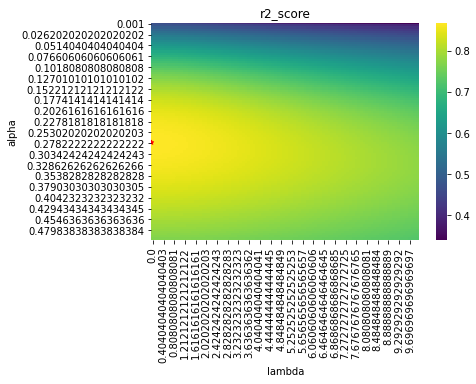

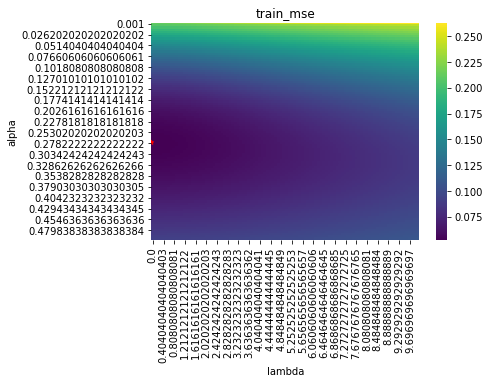

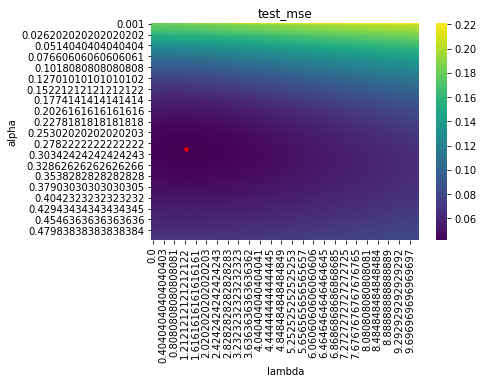

alpha    lambda        r2  train_mse  test_mse  \
best_r2         0.278222  0.000000  0.868413   0.052433  0.043883   
best_train_mse  0.278222  0.000000  0.868413   0.052433  0.043883   
best_test_mse   0.293343  1.313131  0.864099   0.054152  0.042088   

                                                              reg  
best_r2                        Ridge(alpha=0.0, random_state=123)  
best_train_mse                 Ridge(alpha=0.0, random_state=123)  
best_test_mse   Ridge(alpha=1.3131313131313131, random_state=123)

In [104]:
df_best = pd.concat(
    [df_res.loc[df_res['r2'] == df_res['r2'].max()],
     df_res.loc[df_res['train_mse'] == df_res['train_mse'].min()],
     df_res.loc[df_res['test_mse'] == df_res['test_mse'].min()]])
df_best.index = ['best_r2', 'best_train_mse', 'best_test_mse']

sns.heatmap(df_res.pivot(index="alpha", columns="lambda", values="r2"), cmap="viridis")
plt.title("r2_score")
l = np.where(np.isclose(lambdas,df_best.loc['best_r2','lambda']))[0][0]
alpha = np.where(np.isclose(alphas,df_best.loc['best_r2','alpha']))[0][0]
plt.scatter(x=l, y=alpha, s=20, marker="*", c='red')
plt.show()

sns.heatmap(df_res.pivot(index="alpha", columns="lambda", values="train_mse"), cmap="viridis")
plt.title("train_mse")
best_train_mse = df_res.loc[df_res['train_mse'].argmin()]
l = np.where(np.isclose(lambdas,df_best.loc['best_train_mse','lambda']))[0][0]
alpha = np.where(np.isclose(alphas,df_best.loc['best_train_mse','alpha']))[0][0]
plt.scatter(x=l, y=alpha, s=20, marker="*", c='red')
plt.show()

sns.heatmap(df_res.pivot(index="alpha", columns="lambda", values="test_mse"), cmap="viridis")
plt.title("test_mse")
best_test_mse = df_res.loc[df_res['test_mse'].argmin()]
l = np.where(np.isclose(lambdas,df_best.loc['best_test_mse','lambda']))[0][0]
alpha = np.where(np.isclose(alphas,df_best.loc['best_test_mse','alpha']))[0][0]
plt.scatter(x=l, y=alpha, s=20, marker="*", c='red')
plt.savefig("data/n_15_beta_5.png")
plt.show()


df_best


### R2 and Lambda Trade-Off

For a given Alpha, R2 increases as Lambda decreases, since it can fits to the train data much better without regularization

In [105]:
import plotly.express as px

fig = px.scatter(df_res, x="alpha", y="r2", color="lambda", title="R2 vs Alpha")
fig.write_html("data/r2_vs_alpha_n5_beta5.html")
fig.show()

In [106]:
# plt.figure(figsize=(15,7))
# sns.scatterplot(data=df_res, x='alpha', y='r2', hue='lambda', palette='viridis')
# plt.title("R2 vs Alpha")
# plt.show()

TODO: extract best alpha for each lambda in terms of r2

Also, it is slightly clear from the plot that there is one best alpha if we fix lambda, in terms of fit to train data:

In [118]:
best_alphas = []
df_max_r2 = df_res.loc[df_res['r2'] == df_res['r2'].max()]
for lam in df_res['lambda'].unique():
    df_lambda = df_res.loc[df_res['lambda'] == lam]
    best_alpha_given_lambda = df_lambda.iloc[df_lambda['r2'].argmax()]
    best_alphas.append(best_alpha_given_lambda)

# There is one best alpha if we fix lambda to any value
print(f"best_alpha_given_lambda_estimator: {np.mean(best_alphas)}\tstd={np.std(best_alphas)}")

TypeError: unsupported operand type(s) for +: 'float' and 'Ridge'

Consider R2 above 0.85 as equals --> we'll prefer the model with the highest lambda

In [47]:
df_high_r2 = df_res[df_res['r2']>0.85]

In [48]:
df_high_r2.loc[df_high_r2['lambda']==df_high_r2['lambda'].max()]

alpha    lambda        r2  train_mse  test_mse  \
1854  0.091727  5.454545  0.850019   0.063340  0.035924   
1954  0.096768  5.454545  0.850535   0.063122  0.035556   
2054  0.101808  5.454545  0.850511   0.063132  0.035384   

                                                   reg  
1854  Ridge(alpha=5.454545454545454, random_state=123)  
1954  Ridge(alpha=5.454545454545454, random_state=123)  
2054  Ridge(alpha=5.454545454545454, random_state=123)

In [56]:
data_with_features = preprocess_reg(df_model, ma_alpha=df_best.loc['best_test_mse', 'alpha'])

Text(0.5, 1.0, 'True vs Predicted AUC')

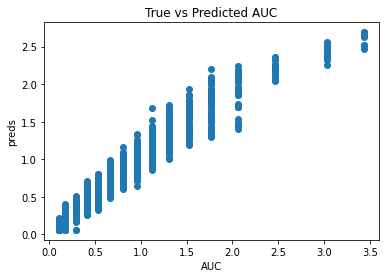

In [73]:
preds = df_best.loc['best_test_mse','reg'].predict(data_with_features[feature_cols])
plt.scatter(data_with_features['AUC'].values, preds)
plt.xlabel("AUC")
plt.ylabel("preds")
plt.title("True vs Predicted AUC")